In [351]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset

In [352]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Debug = False

### 模型定义

In [353]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, conv_input, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.conv=nn.Conv1d(conv_input,conv_input,1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True).to(device)
        
        #self.fc1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x=self.conv(x)
        
        h0 = torch.randn((self.num_layers, x.shape[0], self.hidden_dim)).to(device) # 初始化隐藏状态
        c0 = torch.randn((self.num_layers, x.shape[0], self.hidden_dim)).to(device) # 初始化细胞状态
        
        output, _ = self.lstm(x,(h0,c0))
        output = self.dropout(output)
        output = self.fc(output[:, -1, :]) 
        return output

### 导入数据

In [354]:
# 创建一个空列表来存储读取的 DataFrames
dataframes_Cap = []
dataframes_EIS = []

# 使用循环读取文件并分配名称
for i in range(1, 9):
    # 构建文件名
    file_name_cap= f"Capacity_data/Data_Capacity_25C{i:02}.txt"
    file_name_EIS = f"EIS_data/EIS_state_V_25C{i:02}.txt"  # 使用状态V
    
    
    if not os.path.isfile(file_name_cap):
        print(f"Cap文件 {file_name_cap} 不存在，跳过...")
        continue
    elif not os.path.isfile(file_name_EIS):
        print(f"EIS文件 {file_name_EIS} 不存在，跳过...")
        continue

    # 读取文件并添加到列表
    df_cap = pd.read_csv(file_name_cap, sep="\t")
    df_EIS = pd.read_csv(file_name_EIS, sep="\t")
    #print(df_cap.columns)
    
    if i == 1 or i==5:
        cap_number = 3
    else:
        cap_number = 5
    
    #剔除表现不佳的电池
    if i == 4 or i == 8:
        continue
    cycle = []
    cap = []
    eis = []
    cycle_max = df_cap[df_cap.columns[1]].max()
    cycle_max2 = df_EIS[df_EIS.columns[1]].max()
    cycle_number = min(cycle_max,cycle_max2)
    
    max_scale = df_cap[df_cap[df_cap.columns[1]]==0][df_cap.columns[cap_number]][:].max()
    for i in range(1,int(cycle_number)+1):
        temp = df_cap[df_cap[df_cap.columns[1]]==i][df_cap.columns[cap_number]][-1:].max()
        temp_EIS_Re = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[3]][:])
        temp_EIS_Im = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[4]][:])
        cycle.append(i)
        cap.append(temp)
        eis.append(np.concatenate((temp_EIS_Re, temp_EIS_Im), axis=0))
    dataframes_Cap.append(cap)
    dataframes_EIS.append(eis)

In [355]:
#将35数据读入

# 使用循环读取文件并分配名称
for i in range(1, 3):
    # 构建文件名
    file_name_cap= f"Capacity_data/Data_Capacity_35C{i:02}.txt"
    file_name_EIS = f"EIS_data/EIS_state_V_35C{i:02}.txt"  # 使用状态V
    
    
    if not os.path.isfile(file_name_cap):
        print(f"Cap文件 {file_name_cap} 不存在，跳过...")
        continue
    elif not os.path.isfile(file_name_EIS):
        print(f"EIS文件 {file_name_EIS} 不存在，跳过...")
        continue

    # 读取文件并添加到列表
    df_cap = pd.read_csv(file_name_cap, sep="\t")
    df_EIS = pd.read_csv(file_name_EIS, sep="\t")
    cap_number = 3
    
    cycle = []
    cap = []
    eis = []
    cycle_max = df_cap[df_cap.columns[1]].max()
    cycle_max2 = df_EIS[df_EIS.columns[1]].max()
    cycle_number = min(cycle_max,cycle_max2)
    
    
    #max_scale = df_cap[df_cap[df_cap.columns[1]]==1][df_cap.columns[cap_number]][-1:].max()
    for i in range(1,int(cycle_number)+1):
        temp = df_cap[df_cap[df_cap.columns[1]]==i][df_cap.columns[cap_number]][-1:].max()
        temp_EIS_Re = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[3]][:])
        temp_EIS_Im = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[4]][:])
        #temp = temp/max_scale
        cycle.append(i)
        cap.append(temp)
        eis.append(np.concatenate((temp_EIS_Re, temp_EIS_Im), axis=0))

    dataframes_Cap.append(cap)
    dataframes_EIS.append(eis)

In [356]:
#将45数据读入
for i in range(1, 3):
    # 构建文件名
    file_name_cap= f"Capacity_data/Data_Capacity_45C{i:02}.txt"
    file_name_EIS = f"EIS_data/EIS_state_V_45C{i:02}.txt"  # 使用状态V
    
    
    if not os.path.isfile(file_name_cap):
        print(f"Cap文件 {file_name_cap} 不存在，跳过...")
        continue
    elif not os.path.isfile(file_name_EIS):
        print(f"EIS文件 {file_name_EIS} 不存在，跳过...")
        continue

    # 读取文件并添加到列表
    df_cap = pd.read_csv(file_name_cap, sep="\t")
    df_EIS = pd.read_csv(file_name_EIS, sep="\t")
    #print(df_cap.columns)
    cap_number = 3
    
    cycle = []
    cap = []
    eis = []
    cycle_max = df_cap[df_cap.columns[1]].max()
    cycle_max2 = df_EIS[df_EIS.columns[1]].max()
    cycle_number = min(cycle_max,cycle_max2)
    
    
    #max_scale = df_cap[df_cap[df_cap.columns[1]]==1][df_cap.columns[cap_number]][-1:].max()
    for i in range(1,int(cycle_number)+1):
        temp = df_cap[df_cap[df_cap.columns[1]]==i][df_cap.columns[cap_number]][-1:].max()
        temp_EIS_Re = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[3]][:])
        temp_EIS_Im = np.array(df_EIS[df_EIS[df_EIS.columns[1]]==i][df_EIS.columns[4]][:])
        #temp = temp/max_scale
        cycle.append(i)
        cap.append(temp)
        eis.append(np.concatenate((temp_EIS_Re, temp_EIS_Im), axis=0))
    dataframes_Cap.append(cap)
    dataframes_EIS.append(eis)

In [357]:
X = []
y = []
for i in range(0,len(dataframes_Cap)):
    for j in range(len(dataframes_Cap[i])):
        X.append(dataframes_EIS[i][j])
        y.append(dataframes_Cap[i][j])
X = np.array(X)
y = np.array(y)
print(X.shape,y.shape)

(2522, 120) (2522,)


In [358]:
# 将EIS的每个实部和每个虚部分别各自归一化
remax = []
immax = []
data={}
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = y.reshape(-1,1)
# 对标签也进行归一化
y = scaler.fit_transform(y)
# 将每份电池单独制作，便于交叉训练和验证, 
start = 0
for i in range(len(dataframes_Cap)):
    feature_name = f'EIS{i+1:02}'
    target_name = f'Cap{i+1:02}'
    n = len(dataframes_Cap[i])
    X_r = X[start:start+n,:60].copy()#将实部整体进行归一化
    X_r_flat = X_r.flatten()
    #取第一个EIS的最大最小值进行归一
    X_r_min = X_r_flat[:60].min()
    
    X_r_max = X_r_flat[:60].max()
    remax.append(X_r_flat[:].max()/X_r_max)
    normalized_Xr_flat = ((X_r_flat.reshape(-1, 1))-X_r_min)/(X_r_max-X_r_min)
    normalized_Xr_data = normalized_Xr_flat.reshape(X[start:start+n,:60].shape)
    #将虚部进行归一化
    X_i = X[start:start+n,60:]
    X_i_flat = X_i.flatten()
    X_i_min = X_i_flat[:60].min()
    X_i_max = X_i_flat[:60].max()

    immax.append(X_i_flat[:].max()/X_i_max)
    normalized_Xi_flat = ((X_i_flat.reshape(-1, 1))-X_i_min)/(X_i_max-X_i_min)
    normalized_Xi_data = normalized_Xi_flat.reshape(X[start:start+n,60:].shape)
    data[feature_name] = np.concatenate((normalized_Xr_data, normalized_Xi_data), axis=1)
    data[feature_name] = data[feature_name].reshape(-1,2, 60)#将数据形式转换为（batch，60，2），实部和虚部作为一个整体特征
    data[feature_name] = data[feature_name].transpose(0, 2, 1)
    data[target_name] = y[start:start+n].reshape(-1,1)
    start += n

In [359]:
if Debug:
    # 检查数据效果
    for i in range(15,20):
        x_plot = data["EIS01"][i][:60]
        y_plot = data["EIS01"][i][60:]
        plt.plot(x_plot, y_plot)
    plt.show()

In [360]:
if Debug:
    # 检查数据效果
    for i in range(15,20):
        x_plot = data["Cap02"][:]
        plt.plot(x_plot)
    plt.show()

In [361]:
start = 0
for i in range(1,11):
    if i == 1:
        trainning_data = data[f"EIS{i:02}"][start:].copy()
        trainning_target = data[f"Cap{i:02}"][start:].copy()
    #剔除测试集
    elif i!=4 and i!= 8 and i!= 10:
    #else:
        trainning_data = np.vstack((trainning_data,data[f"EIS{i:02}"][start:]))
        trainning_target = np.vstack((trainning_target,data[f"Cap{i:02}"][start:]))

In [362]:
trainning_data = torch.tensor(trainning_data, dtype=torch.float32)
trainning_target = torch.tensor(trainning_target, dtype=torch.float32)

### Train process

In [363]:
# 初始化模型、损失函数和优化器
input_size = 2 # 特征数量
hidden_size = 128
num_layers = 5
output_size = 1
conv_input = 60
batch_size = 128
epochs = 1500
n_splits = 5

In [364]:
from sklearn.model_selection import KFold  

In [365]:
import gc
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()
gc_collect()

In [366]:
kf = KFold(n_splits=n_splits, shuffle=True)

model_number = 0
for train_idx, val_idx in kf.split(trainning_data):  
    train_X, val_X = trainning_data[train_idx], trainning_data[val_idx]  
    train_y, val_y = trainning_target[train_idx], trainning_target[val_idx]  
    train_dataset = TensorDataset(train_X, train_y)  
    val_dataset = TensorDataset(val_X, val_y)  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
    model = LSTMModel(conv_input, input_size, hidden_size, num_layers, output_size) 
    model = model.to(device)
    criterion = nn.MSELoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.0001,betas=(0.5,0.999))  
     
    for epoch in range(epochs):
        model.train() 
        for i, (inputs, labels) in enumerate(train_loader):  
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)  
                val_loss = criterion(outputs, labels)    
        if epoch%100 ==0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}') 
    torch.save(model.state_dict(), f"model_weights/CNNBiLSTM/test{model_number}.pth")
    model_number += 1

Epoch [1/1500], Loss: 0.16761112213134766, Validation Loss: 0.19776761531829834
Epoch [101/1500], Loss: 0.01155400462448597, Validation Loss: 0.008247360587120056
Epoch [201/1500], Loss: 0.003622722811996937, Validation Loss: 0.009837792254984379
Epoch [301/1500], Loss: 0.0028921053744852543, Validation Loss: 0.007678118068724871
Epoch [401/1500], Loss: 0.000994412461295724, Validation Loss: 0.005270457826554775
Epoch [501/1500], Loss: 0.0003821564605459571, Validation Loss: 0.0008422863320447505
Epoch [601/1500], Loss: 0.001710057957097888, Validation Loss: 0.0001082515373127535
Epoch [701/1500], Loss: 0.00046519431634806097, Validation Loss: 5.9222133131697774e-05
Epoch [801/1500], Loss: 0.0013398963492363691, Validation Loss: 5.065718505647965e-05
Epoch [901/1500], Loss: 0.0005116979009471834, Validation Loss: 0.0004331945674493909
Epoch [1001/1500], Loss: 0.0013475710293278098, Validation Loss: 1.0787805877043866e-05
Epoch [1101/1500], Loss: 0.0010007842211052775, Validation Loss: 

In [367]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

train RMSE:  1.278688730166763
train R2:  1.1001446431678799


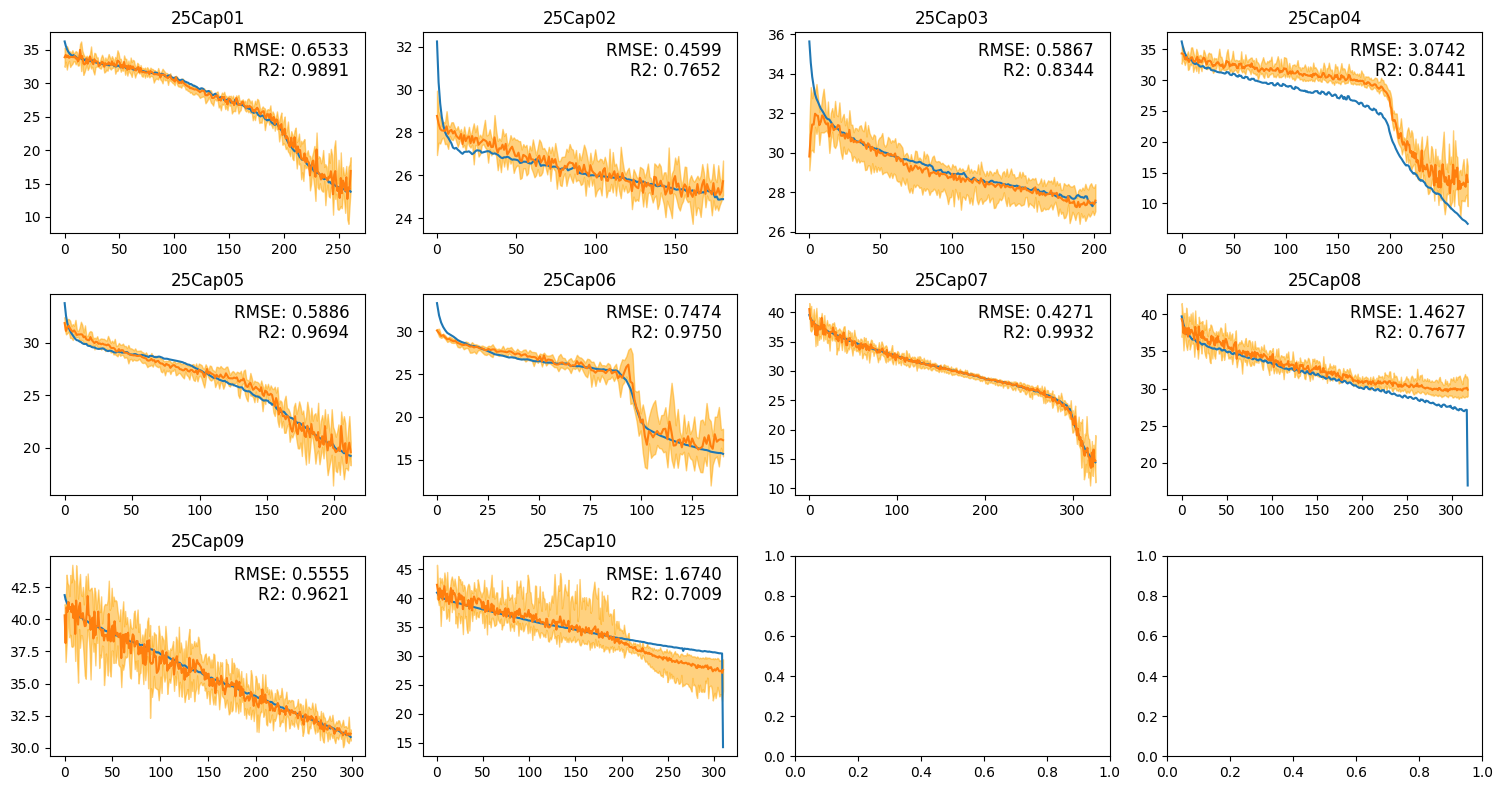

In [368]:
# 创建画布  
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))  
ID = 1
title_name = 1
start = 0
mean_RMSE_train = 0
mean_RMSE_test = 0
mean_R2_train = 0
mean_R2_test = 0
model = LSTMModel(conv_input, input_size, hidden_size, num_layers, output_size) 
model = model.to(device)

# 在每个小区域中绘制图像  
for i in range(3):  
    for j in range(4):
        result = []
        x = torch.tensor(data[f"EIS{ID:02}"], dtype=torch.float32)
        for k in range(n_splits):
            model.load_state_dict(torch.load(f"model_weights/CNNBiLSTM/test{k}.pth",
                                              map_location=torch.device(device)))
            out = model(x.to(device))
            out = out.cpu()
            out = out.detach().numpy()
            out = scaler.inverse_transform(out)
            result.append(out)
        result = np.array(result)
        out = np.mean(result, axis=0)
        out_upper = np.max(result, axis=0)
        out_upper = np.squeeze(out_upper)
        out_lower = np.min(result, axis=0)
        out_lower = np.squeeze(out_lower)
        true = data[f"Cap{ID:02}"]
        true = scaler.inverse_transform(true)
        MSE = mean_squared_error(out[start:], true[start:]) 
        R2_result = r2_score(true[start:], out[start:]) 
        RMSE_result = math.sqrt(MSE)
        mean_RMSE_train += RMSE_result
        mean_R2_train += R2_result
        RMSE_str = "{:.4f}".format(RMSE_result)
        R2_str = "{:.4f}".format(R2_result)
        x = np.linspace(0,x.shape[0],x.shape[0])
        axs[i, j].plot(x[start:], true[start:])
        axs[i, j].plot(x[start:], out[start:])
        axs[i, j].fill_between(x[start:], out_upper[start:], out_lower[start:], color='orange', alpha=0.5)
        axs[i, j].set_title(f"25Cap{title_name:02}")
        axs[i, j].text(0.95, 0.95, "RMSE: "+ RMSE_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
        axs[i, j].text(0.95, 0.85, "R2: "+ R2_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
         # 使用循环将数组中的每个元素写入文件
        with open(f"data/Nature_Cap_train{title_name:02}", 'w') as file:
            for item in range(out[start:].shape[0]):
                out_number = round(float(out[start:][item].flatten()), 4)
                #file.write(str(out_number) + '\t'+str(out_upper[start:][item])+ '\t'+str(out_lower[start:][item])+ '\n')
                file.write(str(out_number)+'\n')
        # 关闭文件
        file.close()
        ID += 1
        title_name += 1
        if ID == 11:
            break



# 调整子图之间的距离  
plt.tight_layout()
plt.savefig('figure_results/cap_alltempalldata_test_5_10_12.png')
print("train RMSE: ", mean_RMSE_train/8)
print("train R2: ", mean_R2_train/8)
  
# 显示图像  
plt.show()